# GROVER lösen SODUKU Problem

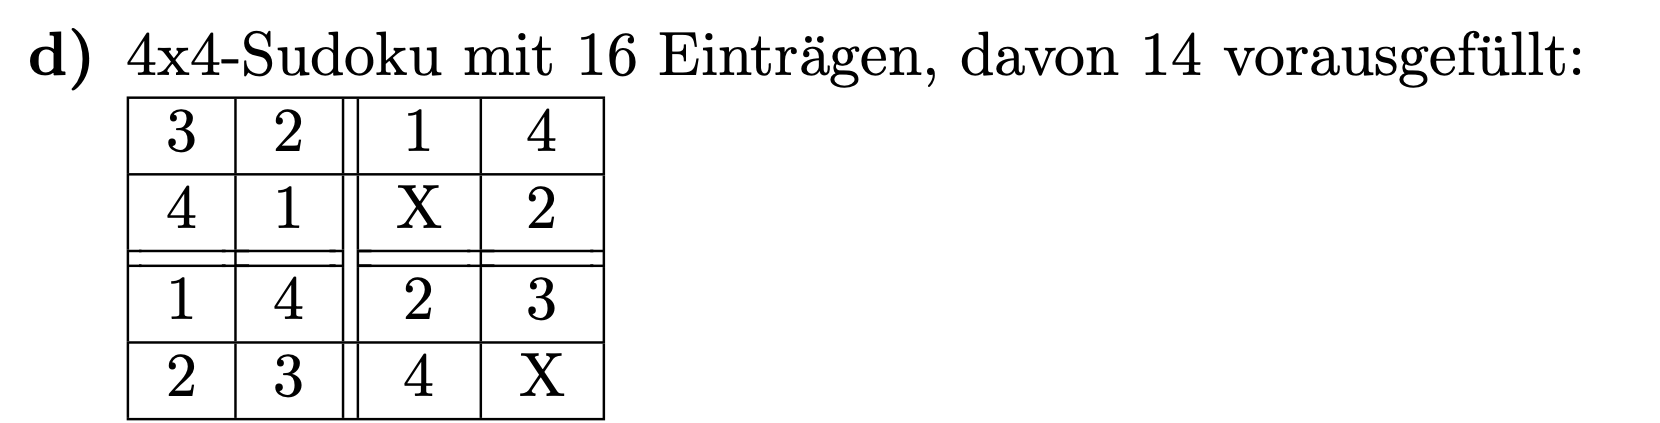

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister,\
    ClassicalRegister,transpile, Aer, IBMQ,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def reflection(qc,x):
    '''Performs reflection around state |0>: adds a negative phase only to state |0>'''
    qc.x(x) #apply X to whole register
    qc.h(x[-1]) #apply hadamard to last qubit
    qc.mcx(x[:-1],x[-1]) #apply multi control x gate
    qc.h(x[-1])
    qc.x(x)
def diffuser(qc,x):
    '''Transforms superposition state |s> -> |0>, reflects about |0>
    and transforms back to |s> again.'''
    qc.h(x)
    reflection(qc,x)
    qc.h(x)

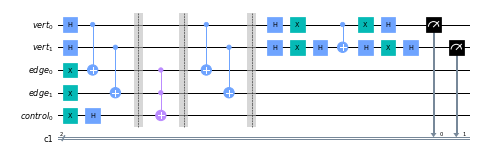

In [4]:
vert = QuantumRegister(2, name ='vert')
edg = QuantumRegister(2, name ='edge')
contr = QuantumRegister(1, name ='control')
cr = ClassicalRegister(2)
qc = QuantumCircuit(vert, edg, contr, cr)

qc.h(vert)
qc.x(edg)
#set control qubit in state |->
qc.x(contr)
qc.h(contr)

#encoding
qc.cx(vert[0], edg[0])
qc.cx(vert[1], edg[1])
#add negative amplitude to the state with all ones (all edges connecting nodes with different colours)
qc.barrier()
qc.mcx(edg,contr)
qc.barrier()
#reverse edge encoding
qc.cx(vert[0], edg[0])
qc.cx(vert[1], edg[1])

qc.barrier()
#diffuser
diffuser(qc,vert[:])

qc.measure(vert[:],cr)
qc.draw('mpl', scale=0.5)

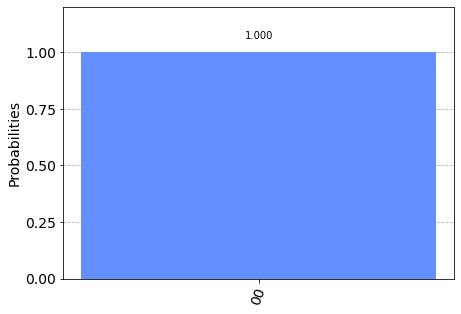

In [5]:
#run on simulator
backend = Aer.get_backend('qasm_simulator') 
result = execute(qc, backend).result()

plot_histogram(result.get_counts())

In [6]:
pass_ = Unroller(['u3', 'cx', 'p'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)
ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))

OrderedDict([('u3', 25), ('cx', 11), ('barrier', 3), ('measure', 2)])
Cost: 135


In [7]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 22
Gate counts: OrderedDict([('u3', 25), ('cx', 11), ('barrier', 3), ('measure', 2)])
Optimization Level 1
Depth: 18
Gate counts: OrderedDict([('u3', 17), ('cx', 11), ('barrier', 3), ('measure', 2)])
Optimization Level 2
Depth: 18
Gate counts: OrderedDict([('u3', 17), ('cx', 11), ('barrier', 3), ('measure', 2)])
Optimization Level 3
Depth: 18
Gate counts: OrderedDict([('u3', 17), ('cx', 11), ('barrier', 3), ('measure', 2)])


In [8]:
pass_ = Unroller(['u3', 'cx', 'p'])
pm = PassManager(pass_)
new_circuit = pm.run(trans_qc)
ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))

OrderedDict([('u3', 17), ('cx', 11), ('barrier', 3), ('measure', 2)])
Cost: 127
